In [2]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('CPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Create a quick overview of the dataset
df.head()

Tensorflow Version: 2.10.0
Num GPUs: 1
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000


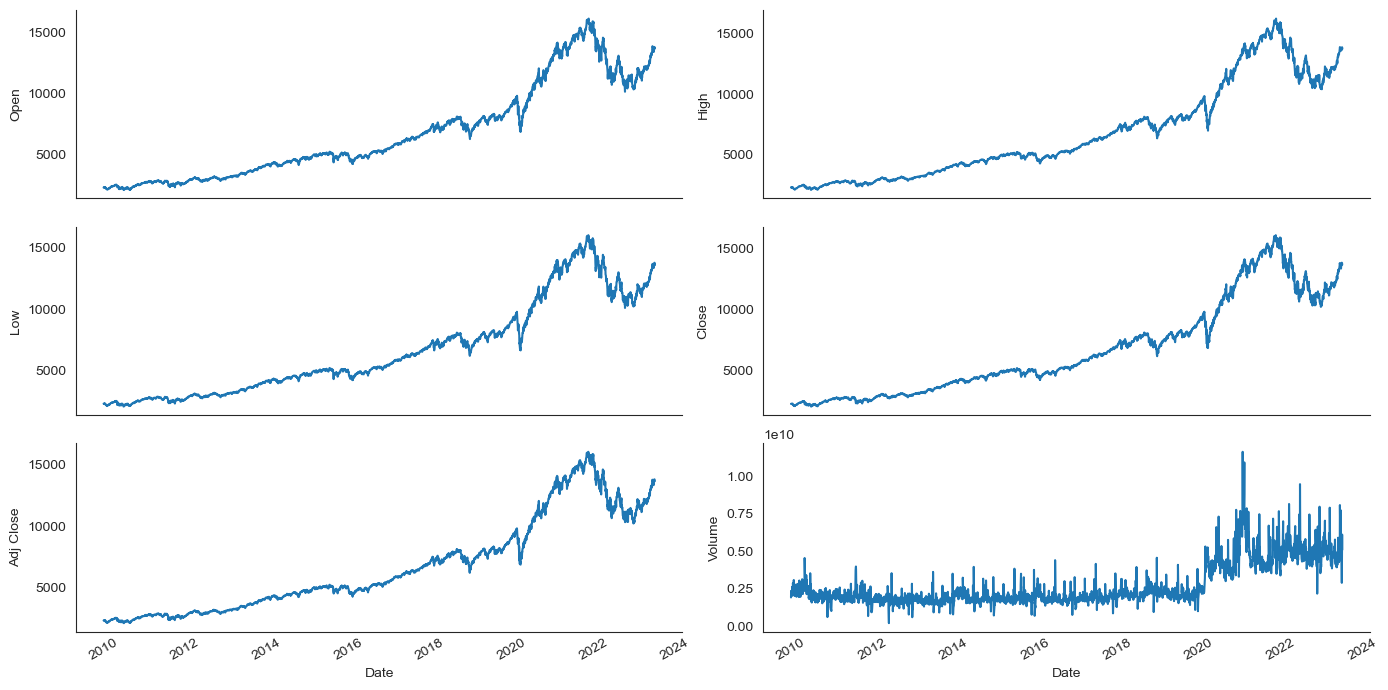

In [3]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [4]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-06-30,13816.679688,13716.160156,13719.980469,13787.919922,4661120000,13787.919922
2023-07-03,13839.089844,13773.410156,13798.700195,13816.769531,2902300000,13816.769531
2023-07-05,13844.500000,13764.250000,13772.099609,13791.650391,5339340000,13791.650391
2023-07-06,13689.519531,13567.250000,13653.169922,13679.040039,6113080000,13679.040039
2023-07-07,13804.509766,13656.730469,13668.070312,13660.719727,5098120000,13660.719727


In [5]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3400, 5)


In [6]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2670, 50, 5) (2670,)
(680, 50, 5) (680,)
0.02128794868212508
0.02128794868212508


In [7]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [10]:
# Training the model
epochs = 3
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/3
167/167 [==============================] - 109s 648ms/step - loss: 9.6299e-05 - val_loss: 6.9657e-04
Epoch 2/3
167/167 [==============================] - 114s 681ms/step - loss: 9.2569e-05 - val_loss: 8.6776e-04
Epoch 3/3
167/167 [==============================] - 121s 724ms/step - loss: 9.7809e-05 - val_loss: 5.4745e-04


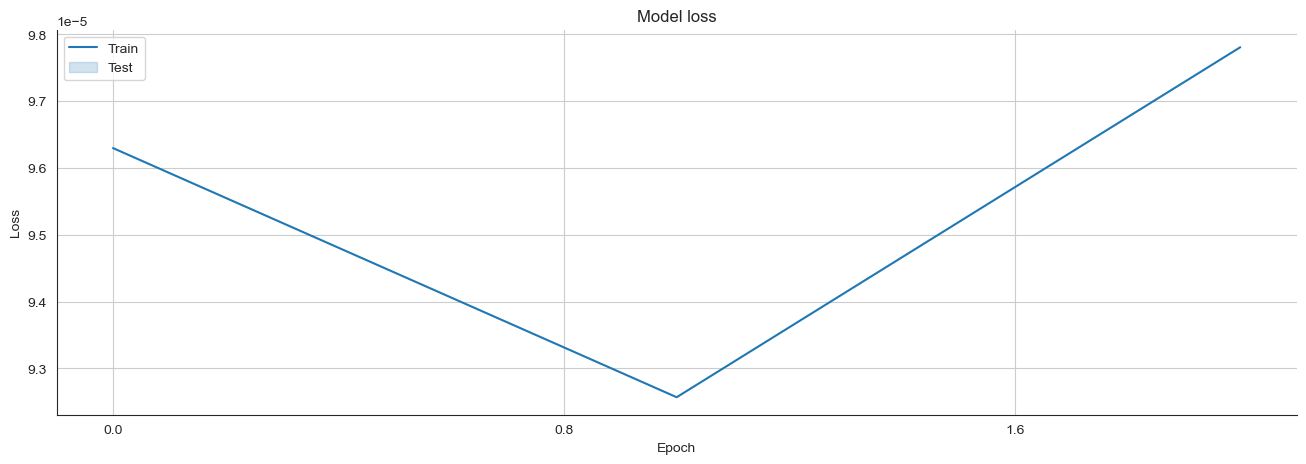

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 2s 34ms/step
Median Absolute Error (MAE): 266.59
Mean Absolute Percentage Error (MAPE): 2.08 %
Median Absolute Percentage Error (MDAPE): 1.85 %


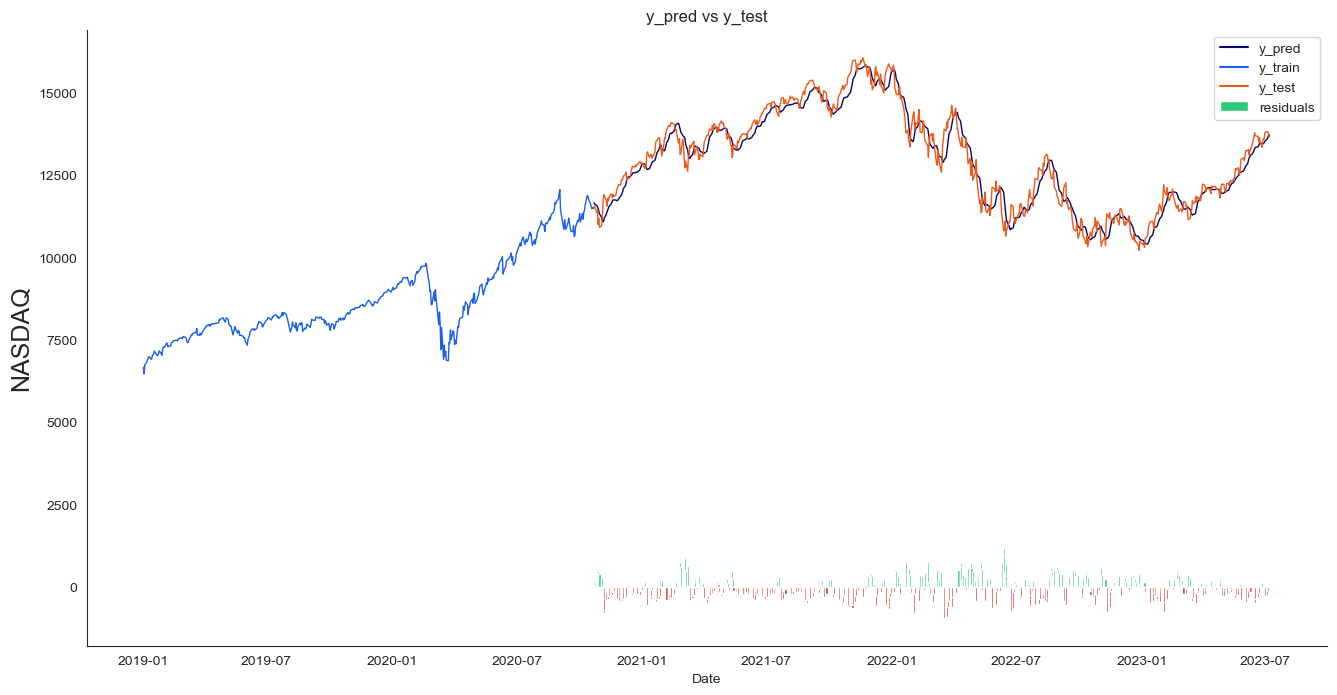

In [13]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [14]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 47ms/step
The close price for NASDAQ at 2023-07-09 was 13660.72
The predicted close price is 13686.3603515625 (+0.19%)


In [15]:
# Anzahl der nächsten Tage, die vorhergesagt werden sollen
num_days = 30

# Vorhersage für jeden Tag treffen
for _ in range(num_days):
    # Aktuelle letzten N Tage abrufen und skalieren
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)
    
    # Leere Liste erstellen und vergangene N Tage hinzufügen
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    
    # X_test in ein Numpy-Array umwandeln und Daten umformen
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    
    # Vorhersage der nächsten 30 Tage speichern
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    
    # Datum für den nächsten Tag berechnen
    next_day = new_df.index[-1] + pd.DateOffset(days=1)
    
    # Aktuelle Vorhersage ausdrucken
    print(f'The predicted close price for {stockname} on {next_day} is {predicted_price}')
    
    # Vorhersage zum neuen DataFrame hinzufügen
    new_df.loc[next_day] = predicted_price
    
    # Aktuellen Tag aus dem DataFrame entfernen
    new_df = new_df[1:]


1/1 [==============================] - 0s 46ms/step
The predicted close price for NASDAQ on 2023-07-08 00:00:00 is 13686.3603515625
1/1 [==============================] - 0s 50ms/step
The predicted close price for NASDAQ on 2023-07-09 00:00:00 is 13773.4501953125
1/1 [==============================] - 0s 51ms/step
The predicted close price for NASDAQ on 2023-07-10 00:00:00 is 13887.66015625
1/1 [==============================] - 0s 50ms/step
The predicted close price for NASDAQ on 2023-07-11 00:00:00 is 14004.9296875
1/1 [==============================] - 0s 50ms/step
The predicted close price for NASDAQ on 2023-07-12 00:00:00 is 14113.900390625
1/1 [==============================] - 0s 46ms/step
The predicted close price for NASDAQ on 2023-07-13 00:00:00 is 14209.240234375
1/1 [==============================] - 0s 42ms/step
The predicted close price for NASDAQ on 2023-07-14 00:00:00 is 14288.66015625
1/1 [==============================] - 0s 40ms/step
The predicted close price for NAS

In [16]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000
...,...,...,...,...,...,...
2023-06-30,13719.980469,13816.679688,13716.160156,13787.919922,13787.919922,4661120000
2023-07-03,13798.700195,13839.089844,13773.410156,13816.769531,13816.769531,2902300000
2023-07-05,13772.099609,13844.500000,13764.250000,13791.650391,13791.650391,5339340000


In [17]:
import pandas as pd
import numpy as np

# Anzahl der nächsten Tage, die vorhergesagt werden sollen
num_days = 30

# Vorhersage für jeden Tag treffen und zum DataFrame hinzufügen
for _ in range(num_days):
    # Aktuelle letzten N Tage abrufen und skalieren
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)
    
    # Leere Liste erstellen und vergangene N Tage hinzufügen
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    
    # X_test in ein Numpy-Array umwandeln und Daten umformen
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    
    # Vorhersage der nächsten 30 Tage speichern
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    
    # Datum für den nächsten Tag berechnen
    next_day = new_df.index[-1] + pd.DateOffset(days=1)
    
    # Vorhersage zum DataFrame hinzufügen
    df.loc[next_day, 'Predicted Price'] = predicted_price
    
    # Neuen Tag zum new_df DataFrame hinzufügen
    new_df.loc[next_day] = predicted_price
    
    # Aktuellen Tag aus dem DataFrame entfernen
    new_df = new_df[1:]


1/1 [==============================] - 0s 40ms/step


In [18]:
new_df

,High,Low,Open,Close,Volume
Date,,,,,
2023-07-18,14445.120117,14445.120117,14445.120117,14445.120117,14445.120117
2023-07-19,14448.209961,14448.209961,14448.209961,14448.209961,14448.209961
2023-07-20,14439.400391,14439.400391,14439.400391,14439.400391,14439.400391
2023-07-21,14420.030273,14420.030273,14420.030273,14420.030273,14420.030273
2023-07-22,14391.450195,14391.450195,14391.450195,14391.450195,14391.450195
2023-07-23,14354.879883,14354.879883,14354.879883,14354.879883,14354.879883
2023-07-24,14311.500000,14311.500000,14311.500000,14311.500000,14311.500000
2023-07-25,14262.349609,14262.349609,14262.349609,14262.349609,14262.349609
2023-07-26,14208.389648,14208.389648,14208.389648,14208.389648,14208.389648


In [19]:
# Den DataFrame "new_df" an den DataFrame "df" anhängen
df = pd.concat([df, new_df])

# Die indexwerte neu zuordnen
df = df.reset_index(drop=True)


In [20]:
df

,Open,High,Low,Close,Adj Close,Volume,Predicted Price
0,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1.931380e+09,NaN
1,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2.367860e+09,NaN
2,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2.253340e+09,NaN
3,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2.270050e+09,NaN
4,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2.145390e+09,NaN
...,...,...,...,...,...,...,...
3475,11865.290039,11865.290039,11865.290039,11865.290039,NaN,1.186529e+04,NaN
3476,11811.389648,11811.389648,11811.389648,11811.389648,NaN,1.181139e+04,NaN
3477,11758.000000,11758.000000,11758.000000,11758.000000,NaN,1.175800e+04,NaN
3478,11705.080078,11705.080078,11705.080078,11705.080078,NaN,1.170508e+04,NaN
